概要:上架介绍了带正则化的线性回归-Ridge回归和Lasso回归；本节介绍弹性网络，逻辑回归。

1.设置绘图环境。

In [14]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.弹性网络。

弹性网络介于 Ridge 回归和 Lasso 回归之间。它的正则项是 Ridge 回归和 Lasso 回归正则项
的简单混合，同时你可以控制它们的混合率 ，当r=0 时，弹性网络就是 Ridge 回归，当r=1
时，其就是 Lasso 回归。

弹性网络的损失函数是：

$$ J(\theta) = MSE(\theta) + r\alpha \sum_{i=1}^{n}{|\theta_i|} + \frac{1-r}{2} \alpha \sum_{i=1}^{n}{\theta_i^2} $$

那么我们该如何选择线性回归，岭回归，Lasso 回归，弹性网络呢？一般来说有一点正则项
的表现更好，因此通常你应该避免使用简单的线性回归。岭回归是一个很好的首选项，但是
如果你的特征仅有少数是真正有用的，你应该选择 Lasso 和弹性网络。

就像我们讨论的那
样，它两能够将无用特征的权重降为零。一般来说，弹性网络的表现要比 Lasso 好，因为当
特征数量比样本的数量大的时候，或者特征之间有很强的相关性时，Lasso 可能会表现的不
规律。

下面是一个使用弹性网络的例子：

In [15]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

3.早期停止法。

对于迭代学习算法，有一种非常特殊的正则化方法，就像梯度下降在验证错误达到最小值时
立即停止训练那样。我们称为早期停止法。

下面是一个例子：

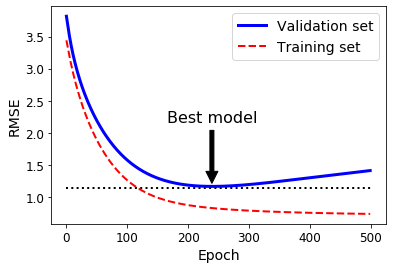

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

上图表示使用批量梯度下降来训练一个非常复
杂的模型（一个高阶多项式回归模型）。随着训练的进行，算法一直学习，它在训练集上的
预测误差（RMSE）自然而然的下降。然而一段时间后，验证误差停止下降，并开始上升。这
意味着模型在训练集上开始出现过拟合。一旦验证错误达到最小值，便提早停止训练。这种
简单有效的正则化方法被 Geoffrey Hinton 称为“完美的免费午餐”

* 随机梯度和小批量梯度下降不是平滑曲线，你可能很难知道它是否达到最小值。 一种解
决方案是，只有在验证误差高于最小值一段时间后（你确信该模型不会变得更好了），
才停止，之后将模型参数回滚到验证误差最小值。

下面是一个早期停止法的基础应用：

In [17]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [18]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

* 注意：当 warm_start=True 时，调用 fit() 方法后，训练会从停下来的地方继续，而不是从头
重新开始。

4.Logistic逻辑回归。

逻辑回归算法可以用于分类。

工作原理：就像线性回归模型一样，Logistic 回归模型计算输入特征的加权和
（加上偏差项），但它不像线性回归模型那样直接输出结果，而是把结果输入 logistic() 函
数进行二次加工后进行输出。

逻辑回归的概率估计：

$$ \hat P = h_\theta(x) = \sigma(\theta^T \cdot x) $$

$\sigma（）$是一个sigmoid函数（图像呈S形），它的输出是一个介于 0 和 1 之间的数字。其公式定义如下：

$$ \sigma(t) = \frac{1}{1+exp(-t)} $$

图像如下：

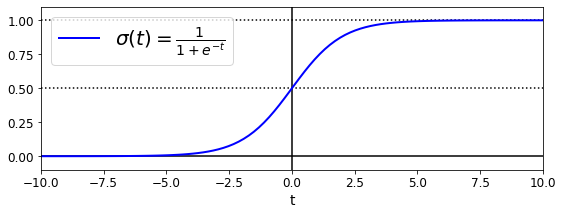

In [19]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

一旦 Logistic 回归模型估计得到了 属于正类的概率$ \hat P $，那它很容易得到预测结果：

$$ \hat{y} = \left \{
    \begin{aligned}
        0, \; \hat{p}<0.5 \\
        1, \; \hat{p}>=0.5 
    \end{aligned} \right.  $$

注意当 t<0 时 $ \sigma(t)$ < 0.5 ，当 t>=0 时 $ \sigma(t)$ >= 0.5，因此当$\theta^T \cdot x$ 是正数的话，逻辑回归模
型输出 1，如果它是负数的话，则输出 0。

单个样本的损失函数是：

$$ c(\theta) = \left \{ 
    \begin{aligned}
        -log(\hat{p}), \;y=1 \\
        -log(1-\hat{p}), \;y=0
    \end{aligned}
    \right.  $$

这个损失函数是合理的，因为当 t 接近 0 时， -log(t) 变得非常大，所以如果模型估计一个正
例概率接近于 0，那么损失函数将会很大，同时如果模型估计一个负例的概率接近 1，那么损
失函数同样会很大。 另一方面，当t 接近于 1 时，-log(t) 接近 0，所以如果模型估计一个正
例概率接近于 0，那么损失函数接近于 0，同时如果模型估计一个负例的概率接近 0，那么损
失函数同样会接近于 0， 这正是我们想的。